# 분류 분석

## 이진 고객 이탈

고객의 웹사이트 광고를 제공하는 마케팅 대행사에서 당사의 고객이탈율이 꽤 높다는 사실을 알게됐습니다.<br>
그 회사에서는 즉시 고객 관리자들을 할당했지만, 어떤 고객이 이탈 할 것인지 예측하는 기계학습 모델을 만들어서 가장 이탈확률이 높은 고객에게 우선적으로 고객 관리자를 배치할 수 있기를 원합니다.<br>
고객이 잠재적 이탈 고객인지 여부를 분류하는 분류모델을 만드세요.

데이터는 customer_churn.csv로 저장돼있습니다. 아래는 각 컬럼의 정의입니다.
- Name : 회사의 최근 담당자의 이름
- Age : 고객의 나이
- Total_Purchase : 구매한 총 광고
- Account_Manager : 바이너리 0 = 고객 관리자 없음, 1 = 고객 관리자 할당됨
- Years : 거래 유지 연도수
- Num_sites : 서비스를 이용 중인 웹사이트 수
- Onboard_date : 마지막 연락처가 등록된 날짜
- Location : 고객 사무실 주소
- Company : 고객 회사의 이름

모델 생성 후에는 고객이 제공하는 new_customers.csv 파일에 저장된 새로운 데이터에 대한 예측값을 제시하세요. <br>
고객은 이 데이터를 통해 관리가 필요한 고객들을 알고 싶어 합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 머신러닝 import
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
# 언더샘플링 import
from imblearn.under_sampling import RandomUnderSampler
# 평가지표 import
from sklearn.metrics import roc_auc_score, roc_curve
#통계모델 import
import statsmodels.api as sm

In [2]:
# matplotlib 한글 폰트 수정 --ver. windows
from matplotlib import font_manager, rc
import matplotlib
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family=font_name)

# 마이너스 표시 깨지지않게 하기
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기

In [3]:
df = pd.read_csv("./data/customer_churn.csv")

### 데이터 확인

In [4]:
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [5]:
df.shape

(900, 10)

In [6]:
df.dtypes

Names               object
Age                float64
Total_Purchase     float64
Account_Manager      int64
Years              float64
Num_Sites          float64
Onboard_date        object
Location            object
Company             object
Churn                int64
dtype: object

In [7]:
# Null값은 없는 것으로 확인됨
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


In [8]:
# 데이터간 단위차이가 크기때문에 스케일링이 필요할 수도 있음
df.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


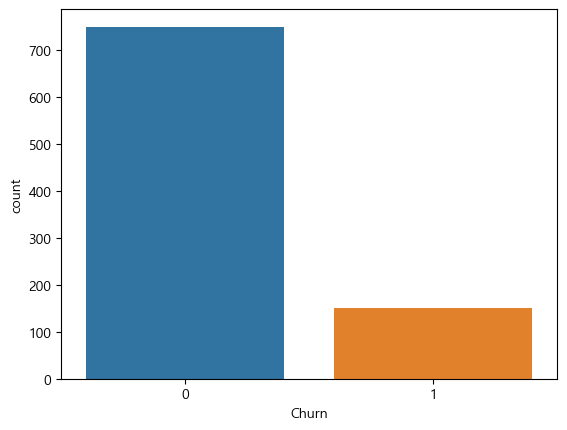

In [9]:
# 종속변수 클래스 분포 시각화
sns.countplot(x = "Churn", data = df)
plt.show()

In [10]:
# 클래스 불균형이 심한 것으로 확인됨. 언더샘플링이나 오버샘플링을 진행하는 것이 좋을 수도 있음
df["Churn"].value_counts()

0    750
1    150
Name: Churn, dtype: int64

In [11]:
# 중복된 이름 있는지 확인. 거의 없는 것으로 확인됨. 제거하는 것이 더 좋을 것 같음
df["Names"].value_counts()

Jennifer Wood        2
Cameron Williams     1
Stacy Marshall       1
Christopher Clark    1
Rose White           1
                    ..
Ashley Smith         1
Sandra Mcintyre      1
Robert Joseph        1
George Chavez        1
Joseph Williams      1
Name: Names, Length: 899, dtype: int64

In [12]:
# 중복된 회사명 있는지 확인. 거의 없는 것으로 확인됨. 제거하는 것이 더 좋을 것 같음
df["Company"].value_counts()

Anderson Group                     4
Williams PLC                       3
Wilson PLC                         3
Smith Group                        2
Williams LLC                       2
                                  ..
Cowan Inc                          1
Cortez Inc                         1
Rodriguez, Moore and Cunningham    1
Bennett Ltd                        1
Robles-Abbott                      1
Name: Company, Length: 873, dtype: int64

In [13]:
# 중복되는 주소는 없음. 제거하는 것이 좋을 것 같음
df["Location"].value_counts()

10265 Elizabeth Mission Barkerburgh, AK 89518            1
4331 Quinn Fords Suite 546 Traceyfort, CO 47194-7606     1
69666 Christian Forges Lake Noah, IL 14397               1
715 Ellis Squares New Kathleenland, NY 05913             1
3004 Nash Freeway North Craigville, CT 24488             1
                                                        ..
3785 Duran Lodge Port Nicholashaven, MH 08892-1815       1
663 White Tunnel Suite 995 Port Joseph, PR 93959-2444    1
10676 Ferguson Ranch Suite 380 Lake Parker, OH 23498     1
95222 Lisa Turnpike South Laurenburgh, NC 33273-8443     1
27252 Olivia Burgs Rivasmouth, MN 80121-6348             1
Name: Location, Length: 900, dtype: int64

In [14]:
# 날짜/시간으로 추정됨, object 타입으로 나타남. year만 추출해서 사용해봐도 괜찮을 것 같음.
df["Onboard_date"].value_counts()

2013-08-30 07:00:40    1
2015-10-06 18:31:32    1
2012-04-22 17:32:15    1
2006-03-29 18:27:06    1
2011-08-29 06:35:54    1
                      ..
2011-10-07 15:43:59    1
2007-09-19 06:55:51    1
2010-08-02 09:34:35    1
2015-04-03 16:15:00    1
2010-09-25 12:16:08    1
Name: Onboard_date, Length: 900, dtype: int64

In [15]:
# 피처 각각에 대한 히스토그램을 출력
def plot_hist(df):
    plt.rcParams["figure.figsize"] = [20, 16]
    fig = plt.figure(1) # 해당 figure에 ID를 매겨줌. 별 의미없음. 1빼도됨.
    
    # df의 열 개수 만큼의 subplot을 출력
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i + 1) # 5행 5열
        plt.hist(df[df.columns[i]], bins = 50) # 0번째컬럼으로 히스토그램, 1번째컬럼으로 히스토그램 ...
        ax.set_title(df.columns[i]) 
        
    plt.tight_layout()
    plt.show()

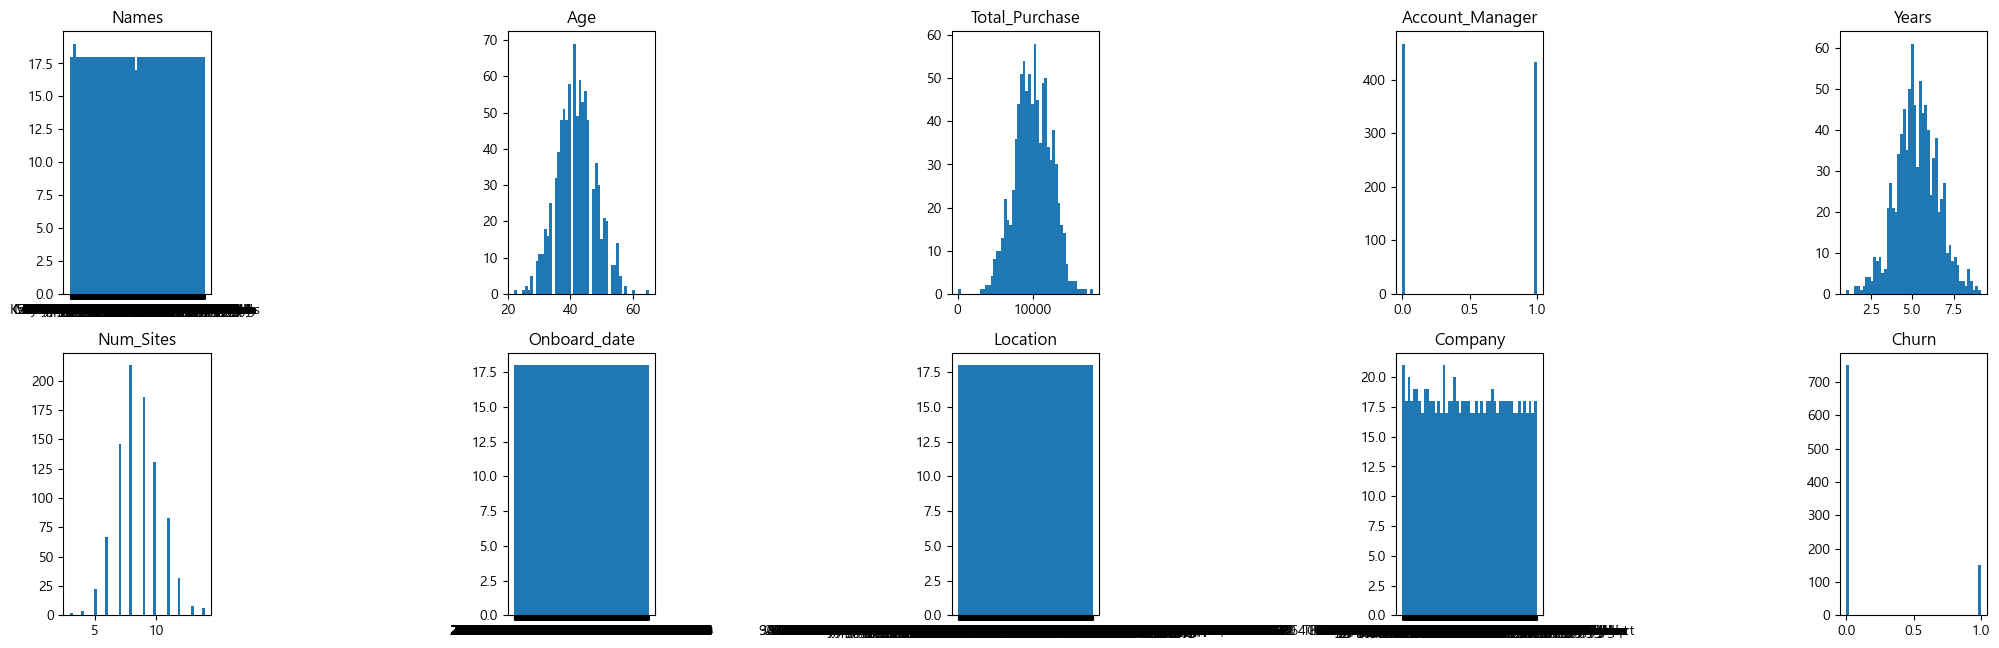

In [16]:
plot_hist(df)

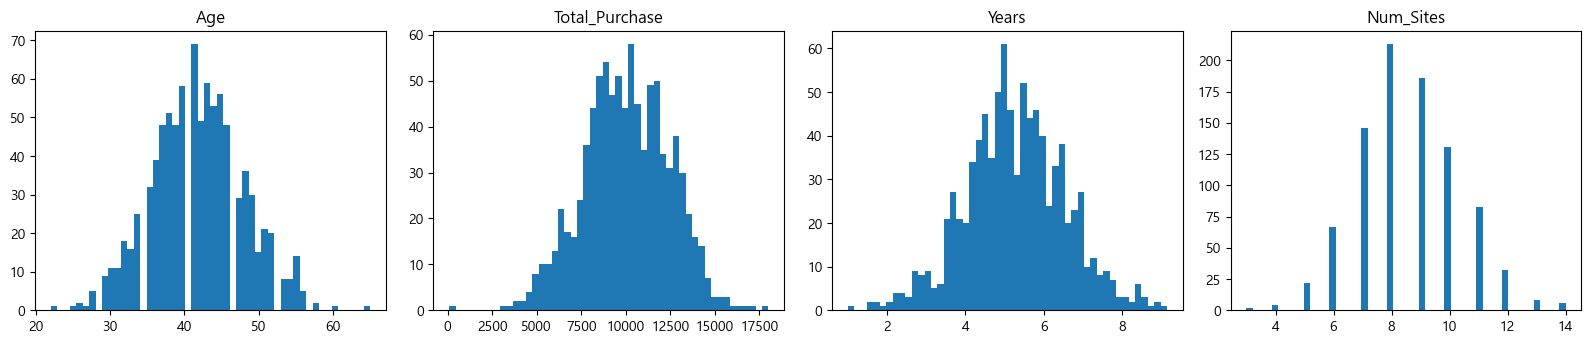

In [17]:
# 위 그래프들중 정규분포를 이루는 데이터들만 따로 그리기
plot_hist(df[["Age", "Total_Purchase", "Years", "Num_Sites"]])

### 이상치확인

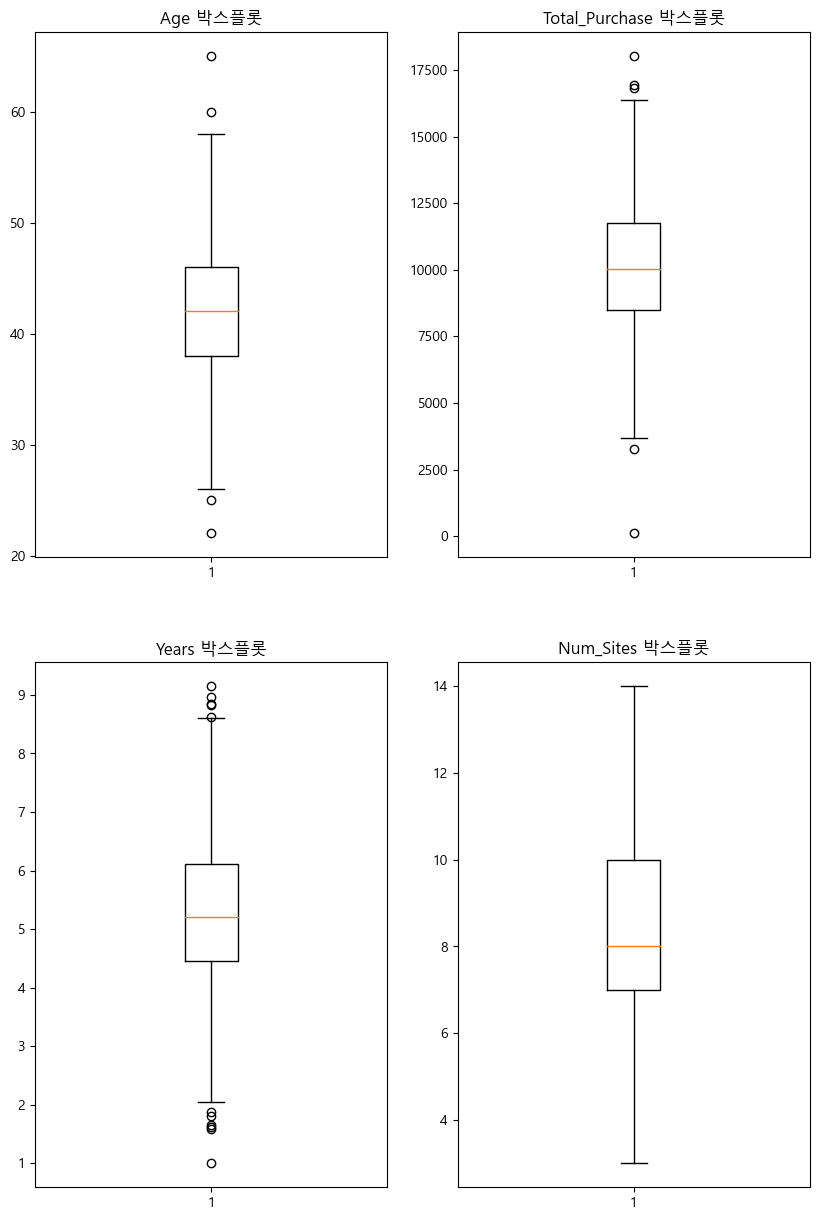

In [18]:
# 그래프 객체 생성 
fig = plt.figure(figsize = (10, 15))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


# axe 객체에 boxplot 메서드로 그래프 출력
ax1.boxplot(x = [df["Age"]])
ax2.boxplot(x = [df["Total_Purchase"]])
ax3.boxplot(x = [df["Years"]])
ax4.boxplot(x = df["Num_Sites"])

ax1.set_title("Age 박스플롯")
ax2.set_title("Total_Purchase 박스플롯")
ax3.set_title("Years 박스플롯")
ax4.set_title("Num_Sites 박스플롯")

plt.show()

- 어느정도의 이상치가 있으니, Robust Scaler 사용을 고려해보면 좋을듯함

### 머신러닝용 데이터 전처리

우리는 수치형 데이터만 이용할 예정입니다. Account_Manager는 다루기 어렵지 않기 때문에 모델학습에 포함할 수도 있겠지만 무작위로 할당된 것이기 때문에 큰 의미가 없을 수 있습니다.

In [19]:
# 사용할 변수들 : Age, Total_Purchase, Years, Num_Sites (위 시각화에서 정규분포 모양을 띄운 변수들만 골라 사용하기)
x = df[["Age","Total_Purchase","Years","Num_Sites"]]
y = df["Churn"]

In [20]:
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify= y, random_state= 196)

In [21]:
# 스케일링
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)

In [22]:
# 랍스터 스케일링
rs = RobustScaler()
robust_train = rs.fit_transform(x_train)
robust_test = rs.transform(x_test)

## 모델훈련

### 로지스틱회귀사용

In [23]:
logi = LogisticRegression()

In [24]:
# 교차검증
scores = cross_validate(logi, scaled_train, y_train, return_train_score= True, n_jobs = -1)

In [25]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.888888888888889 0.8833333333333334


In [26]:
# Robust 스케일링 교차검증
scores = cross_validate(logi, robust_train, y_train, return_train_score= True, n_jobs = -1)

In [27]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.8871527777777779 0.8805555555555555


- Standard Scaler의 성능이 조금 더 우수함

### 의사결정나무사용

In [28]:
dt = DecisionTreeClassifier(max_depth = 5, random_state= 196)

In [29]:
# 교차검증
scores = cross_validate(dt, x_train, y_train, return_train_score= True, n_jobs = -1)

In [30]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.9253472222222223 0.8569444444444445


In [31]:
# 특성 중요도 확인
dt.fit(x_train, y_train)
print(dt.feature_importances_)

[0.14107484 0.0999131  0.14289874 0.61611332]


### 랜덤포레스트사용

In [32]:
rf = RandomForestClassifier(n_jobs= -1, random_state= 196)

In [33]:
# 교차검증
scores = cross_validate(rf, x_train, y_train, return_train_score= True, n_jobs = -1)

In [34]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

1.0 0.8763888888888889


- 과대적합일 가능성이 높음

In [35]:
# 특성 중요도 확인
rf.fit(x_train, y_train)
print(rf.feature_importances_)

[0.15056044 0.20503689 0.25702267 0.38738   ]


### 엑스트라트리 사용

In [36]:
et = ExtraTreesClassifier(n_jobs= -1, random_state= 196)

In [37]:
# 교차검증
scores = cross_validate(et, x_train, y_train, return_train_score= True, n_jobs = -1)

In [38]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

1.0 0.8638888888888889


- 과대적합일 가능성이 높음

In [39]:
# 특성 중요도 확인
et.fit(x_train, y_train)
print(et.feature_importances_)

[0.17947555 0.19667888 0.23558423 0.38826134]


### 그레디언트 부스팅 사용

In [40]:
gb = GradientBoostingClassifier(random_state= 196)

In [41]:
scores = cross_validate(gb, x_train, y_train, return_train_score= True, n_jobs= -1)

In [42]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.9708333333333332 0.8666666666666666


In [43]:
# 특성 중요도 확인
gb.fit(x_train, y_train)
gb.feature_importances_

array([0.07445893, 0.15081861, 0.24568816, 0.5290343 ])

### 결과분석

- 로지스틱회귀가 제일 성능이 좋은 것으로 나타남

### 평가용 데이터에 같은 전처리기법 적용

- cross_validate 교차검증으로 AUC 계산하고, 아래 df_submit 결과물까지 두개 강사님께 제출

In [44]:
df_submit = pd.read_csv("./data/new_customers.csv", index_col = False)

In [45]:
df_submit

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company
0,Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd
1,Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson
2,Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson
3,Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden
4,Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC
5,Jessica Drake,22.0,8445.26,1,3.46,14.0,2011-02-04 19:29:27,1148 Tina Stravenue Apt. 978 South Carlos TX 2...,Parks-Robbins


In [46]:
df_submit_x = df_submit[["Age", "Total_Purchase", "Years", "Num_Sites"]]

In [47]:
# 스케일링
scaled_df_submit_x = ss.transform(df_submit_x)

### 예측하기

In [48]:
# 로지스틱 모델 구현 
logi.fit(scaled_train, y_train)

LogisticRegression()

In [49]:
# 예측
logi.predict(scaled_df_submit_x)

array([0, 1, 1, 1, 0, 1], dtype=int64)

## 평가하기

In [50]:
y_pred = logi.predict_proba(scaled_test)[:,1]

In [51]:
auc = roc_auc_score(y_test, y_pred)

In [52]:
print(auc)

0.922


In [53]:
# 교차 검증을 사용한 AUC 계산하기
cv_scores = cross_validate(logi, scaled_train, y_train, cv=5, scoring="roc_auc" )

In [54]:
# 각 fold의 AUC 출력하기
cv_scores

{'fit_time': array([0.00377965, 0.00398445, 0.        , 0.01743412, 0.        ]),
 'score_time': array([0.00501513, 0.        , 0.        , 0.        , 0.01397228]),
 'test_score': array([0.89618056, 0.88993056, 0.92743056, 0.91076389, 0.89201389])}

In [55]:
# 평균 AUC 계산하기
mean_auc = np.mean(cv_scores["test_score"])
mean_auc

0.9032638888888889

## 언더샘플링 진행

In [56]:
# 임시 변수명 적용 (imblearn 에서는 작동하지 않는 변수명들이 있기때문. 라이브러리 문제)
x_train_re = x_train.copy()
y_train_re = y_train.copy()

# 컬럼 5개 만들기
x_tmp_name = [f"X{i}" for i in range(1, 5)]
y_tmp_name = ["y1"]

In [57]:
# 만든 변수명 적용
x_train_re.columns = x_tmp_name
y_train_re.columns = y_tmp_name

In [58]:
# 언더샘플링 적용
x_train_under, y_train_under = RandomUnderSampler(random_state=196).fit_resample(x_train_re, y_train_re)

In [59]:
y_train_under.value_counts()

0    120
1    120
Name: Churn, dtype: int64

In [60]:
# 컬럼명 복구
x_train_under.columns = list(x_train)
y_train_under.columns = list(y_train)

In [61]:
# 스케일링 
scaled_under_x_train = ss.transform(x_train_under)

In [62]:
# 학습셋 모델 학습 
logi2 = LogisticRegression()
logi2.fit(scaled_under_x_train, y_train_under)

LogisticRegression()

In [63]:
# 스케일링 평가용 데이터에 적용
scaled_df_submit_x = ss.transform(df_submit_x)

In [64]:
# 예측해보기 
logi2.predict(scaled_df_submit_x)

array([0, 1, 1, 1, 0, 1], dtype=int64)

## 평가하기

In [65]:
# 교차 검증을 사용한 AUC 계산하기
cv_scores = cross_val_score(logi2, scaled_under_x_train, y_train_under, cv=5, scoring='roc_auc')
# 각 fold의 AUC 출력하기
cv_scores
# 평균 AUC 계산하기
mean_auc = cv_scores.mean()
mean_auc

0.9121527777777778

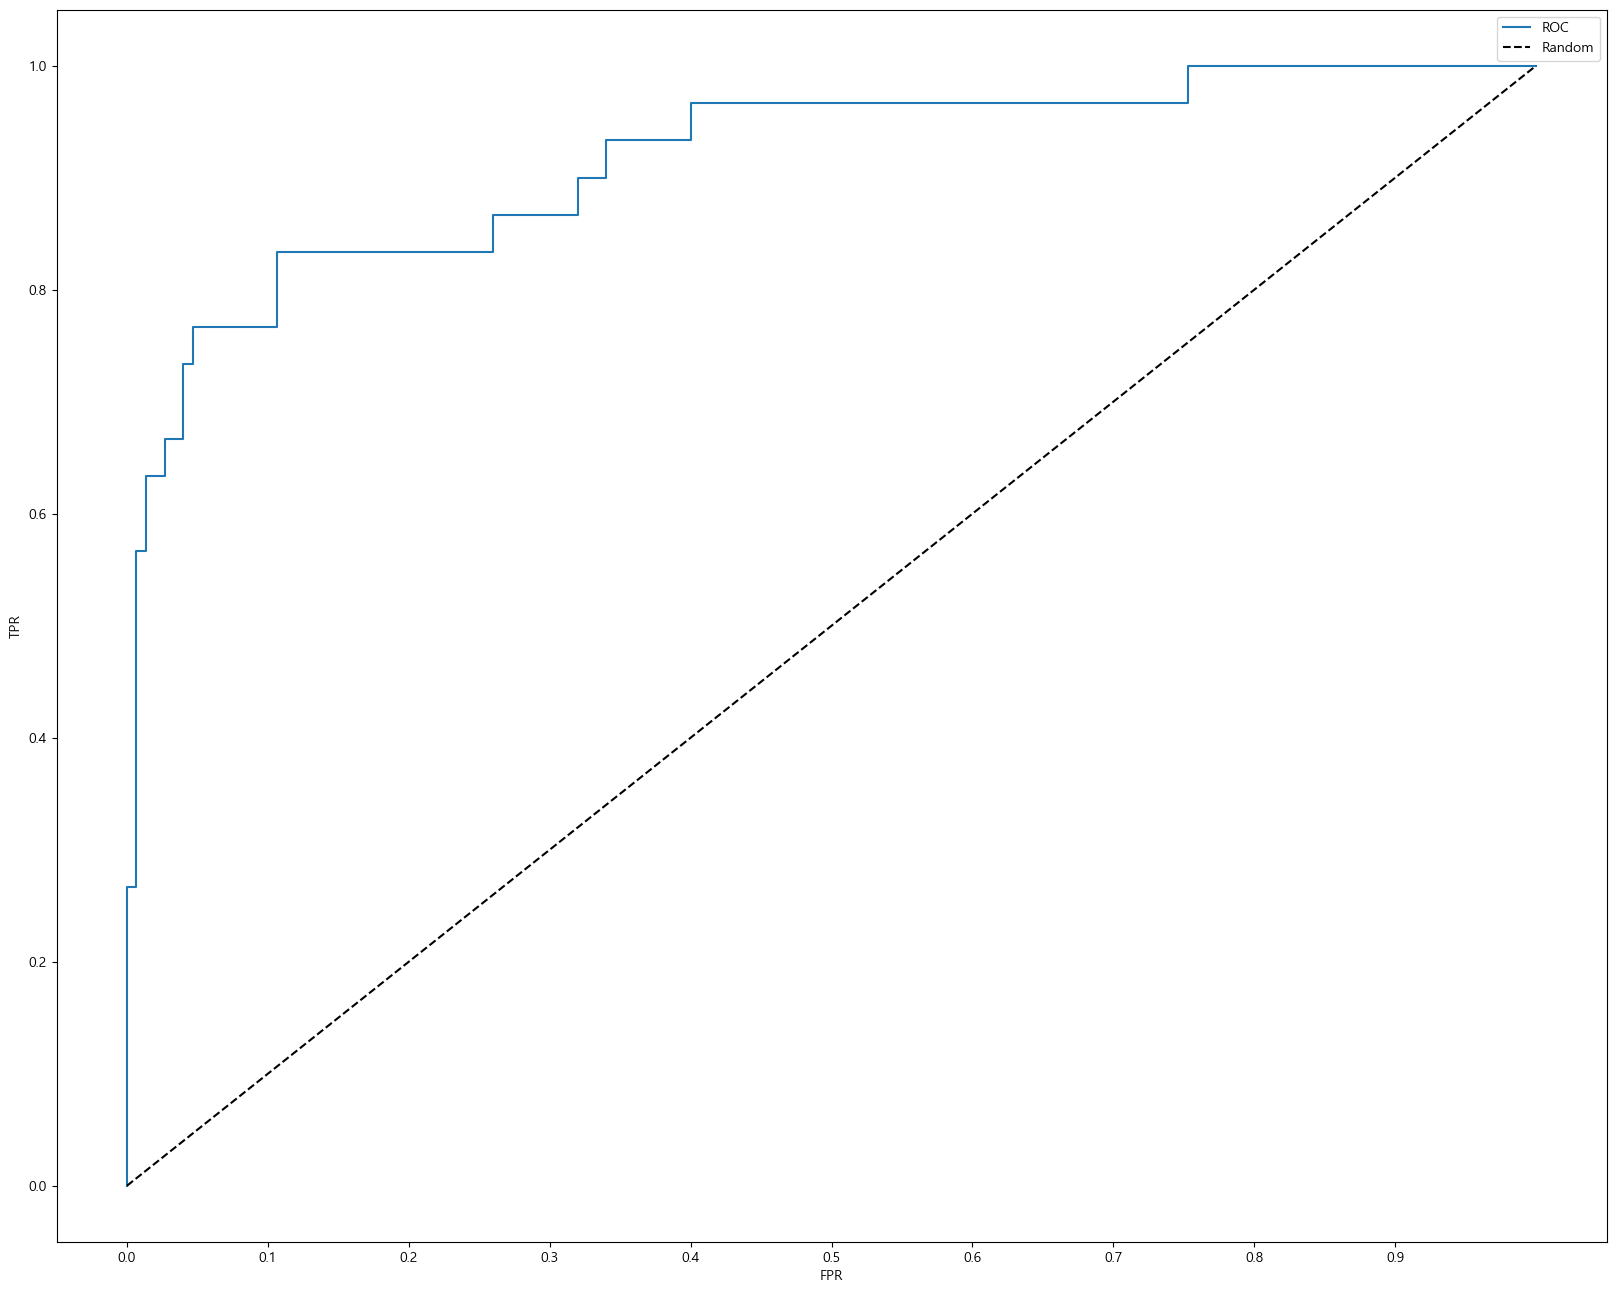

In [66]:
# ROC 커브 그리기
pred_proba_class1 = logi2.predict_proba(scaled_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test,
                                  pred_proba_class1)

plt.figure()
plt.plot(fprs, tprs, label = "ROC")
plt.plot([0, 1], [0, 1], "k--", label = "Random")

plt.xticks(np.round(np.arange(0, 1, 0.1), 2))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

## 통계모델

In [67]:
# 로지스틱 모델 통계모델로 학습
model = sm.Logit(y_train_under, x_train_under)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.548201
         Iterations 6


In [68]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                  240
Model:                          Logit   Df Residuals:                      236
Method:                           MLE   Df Model:                            3
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                  0.2091
Time:                        15:15:42   Log-Likelihood:                -131.57
converged:                       True   LL-Null:                       -166.36
Covariance Type:            nonrobust   LLR p-value:                 5.265e-15
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age               -0.0691      0.019     -3.671      0.000      -0.106      -0.032
Total_Purchase    -0.0003   6.05e-05     -4.403      0.000      -0.000      -0.000
Years              0.0608      0.109      0.560      0.576      -0.152       0.274
Num_Sites          0.5761      0.091      6.354      0.000       0.398       0.754
==================================================================================
"""

- Years 변수의 p-value가 0.05보다 높기때문에 해당 컬럼을 제거해보면 성능이 더 좋아질 수도 있음

## 정리

- 선택한 변수들 : "Age", "Total_Purchase", "Years", "Num_Sites" (정규분포를 띄는 변수들만 선택해서 사용함)

- 구현한 머신러닝 모델중에서는(로지스틱,의사결정나무,랜덤포레스트,엑스트라 트리, 그레디언트부스트) 로지스틱회귀모델이 제일 우수한 성능을 보임.

- 세개의 변수에서 이상치들이 있어서 Robust 스케일러를 사용해보았지만, Standard Scaler를 사용했을 때 성능이 더 우수했음.

- 언더샘플링을 진행하니 성능이 조금 더 좋아진 것으로 보임. 데이터 균형을 맞추는 것이 도움이 되는걸로 나타남.
    - 하지만 언더샘플링을 진행하게되면 데이터의 수가 너무 적음 (각 120개). 오버샘플링을 구현해보면 좋을 수도 있음
    
- 앞서 사용한 변수 4개로 로지스틱 회귀모델을 구현했을 때, 이탈고객을 예측할 확률은 대략 88%이며, AUC 점수 0.9118의 성능을 띔.
